In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans
from numba import jit, autojit
from numpy.linalg import norm
import time

In [2]:
def tile_image(tile_rows, tile_cols, row_overlap, col_overlap, im):
    im_rows = im.shape[0]
    im_cols = im.shape[1]
    im_channels = im.shape[2]
    
    row_stride = (tile_rows - row_overlap)
    n_tiles_row = int(np.ceil((im_rows - tile_rows)/row_stride) + 1)
    im_padded_rows = (n_tiles_row - 1)*row_stride + tile_rows
    col_stride = (tile_cols - col_overlap)
    n_tiles_col = int(np.ceil((im_cols - tile_cols)/col_stride) + 1)
    im_padded_cols = (n_tiles_col - 1)*col_stride + tile_cols
    
    pad_rows = im_padded_rows - im_rows
    pad_cols = im_padded_cols - im_cols
    im_padded = np.pad(im, ((0,pad_rows),(0,pad_cols),(0,0)), 'wrap')
            
    tiles = [im_padded[i*row_stride:i*row_stride+tile_rows,j*col_stride:j*col_stride+tile_cols,:] for i in range(n_tiles_row) for j in range (n_tiles_col)]
    return tiles, n_tiles_row, n_tiles_col

In [3]:
@autojit
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.001, max_iter=250):
    n, p = xs.shape
    k = len(pis)
    print(n, p, k)
    mus_old = mus
    for i in range(max_iter):
        start_time = time.perf_counter()

        # E-step & log likelihood
        ws = e_step(k, n, xs, pis, mus_old, sigmas)
        # M-step
        pis, mus_new, sigmas = m_step(k, n, p, mus_old, ws, xs, sigmas)

        end_time = time.perf_counter()
        print('Iteration: %d, Elapse time: %.2f sec' % (i, end_time - start_time))
        
        dist = distance(mus_old, mus_new)
#         print('Mean distance mus_old & mus_new: %.4f' % (dist))
        if dist < tol:
            break
        mus_old = mus_new

    return pis, mus_old, sigmas

In [4]:
@autojit
def distance(mus_old, mus_new):
    dist = 0
    for i in range(len(mus_old)):
        dist += norm(mus_old[i] - mus_new[i])
    return dist/len(mus_old)

In [5]:
@autojit
def e_step(k, n, xs, pis, mus, sigmas):
    dmins_s = np.zeros((n, k))
    dmins = np.zeros(n)
    for i in range(n):
        for j in range(k):
            dmins_s[i, j] = norm(xs[i] - mus[j])
        dmins[i] = min(dmins_s[i])
    ws = np.zeros((k, n))
    for j in range(k):
        for i in range(n):
            ys = xs[i] - mus[j]
            zs = -(np.dot(ys.T, ys) - dmins[i]**2)/2
            ws[j, i] = pis[j] * np.exp(zs)
    ws /= ws.sum(0)
    return ws

In [6]:
@autojit
def m_step(k, n, p, mus, ws, xs, sigmas):
    pis = np.mean(ws, axis = 1)
    mus = np.zeros((k, p))
    for j in range(k):
        mus[j] = np.dot(ws[j, :], xs)
        mus[j] /= ws[j, :].sum()
    return pis, mus, sigmas

In [7]:
@autojit
def init(k, im):
    xs = im
    n, m, c = xs.shape
    xs = xs.reshape(n*m, c)

    pis = np.random.random(k)
    pis /= pis.sum()
#     mus = np.random.random((k,c))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(xs)
    mus = kmeans.cluster_centers_
    sigmas = np.array([np.eye(c)]*k)
    return xs, pis, mus, sigmas

In [8]:
@autojit
def recon_im_2(n, m, c, k, xs, mus, sigmas):
    im_new = np.zeros((n*m, c))
    xs = xs.reshape(n*m, c)
    for i in range(n*m):
        maxlikelihood = 0
        label = 0
        for j in range(k):
            likelihood = mvn(mus[j], sigmas[j]).pdf(xs[i])
            if likelihood > maxlikelihood:
                maxlikelihood = likelihood
                label = j
        im_new[i] = mus[label]
    return im_new

In [9]:
@autojit
def recon_im(n, m, c, k, xs, mus, sigmas):
    im_new = np.zeros((n*m, c))
    xs = xs.reshape(n*m, c)
    for i in range(n*m):
        min_dist = 100
        label = 0
        for j in range(k):
            dist = norm(xs[i] - mus[j])
            if dist < min_dist:
                min_dist = dist
                label = j
        im_new[i] = mus[label]
    return im_new

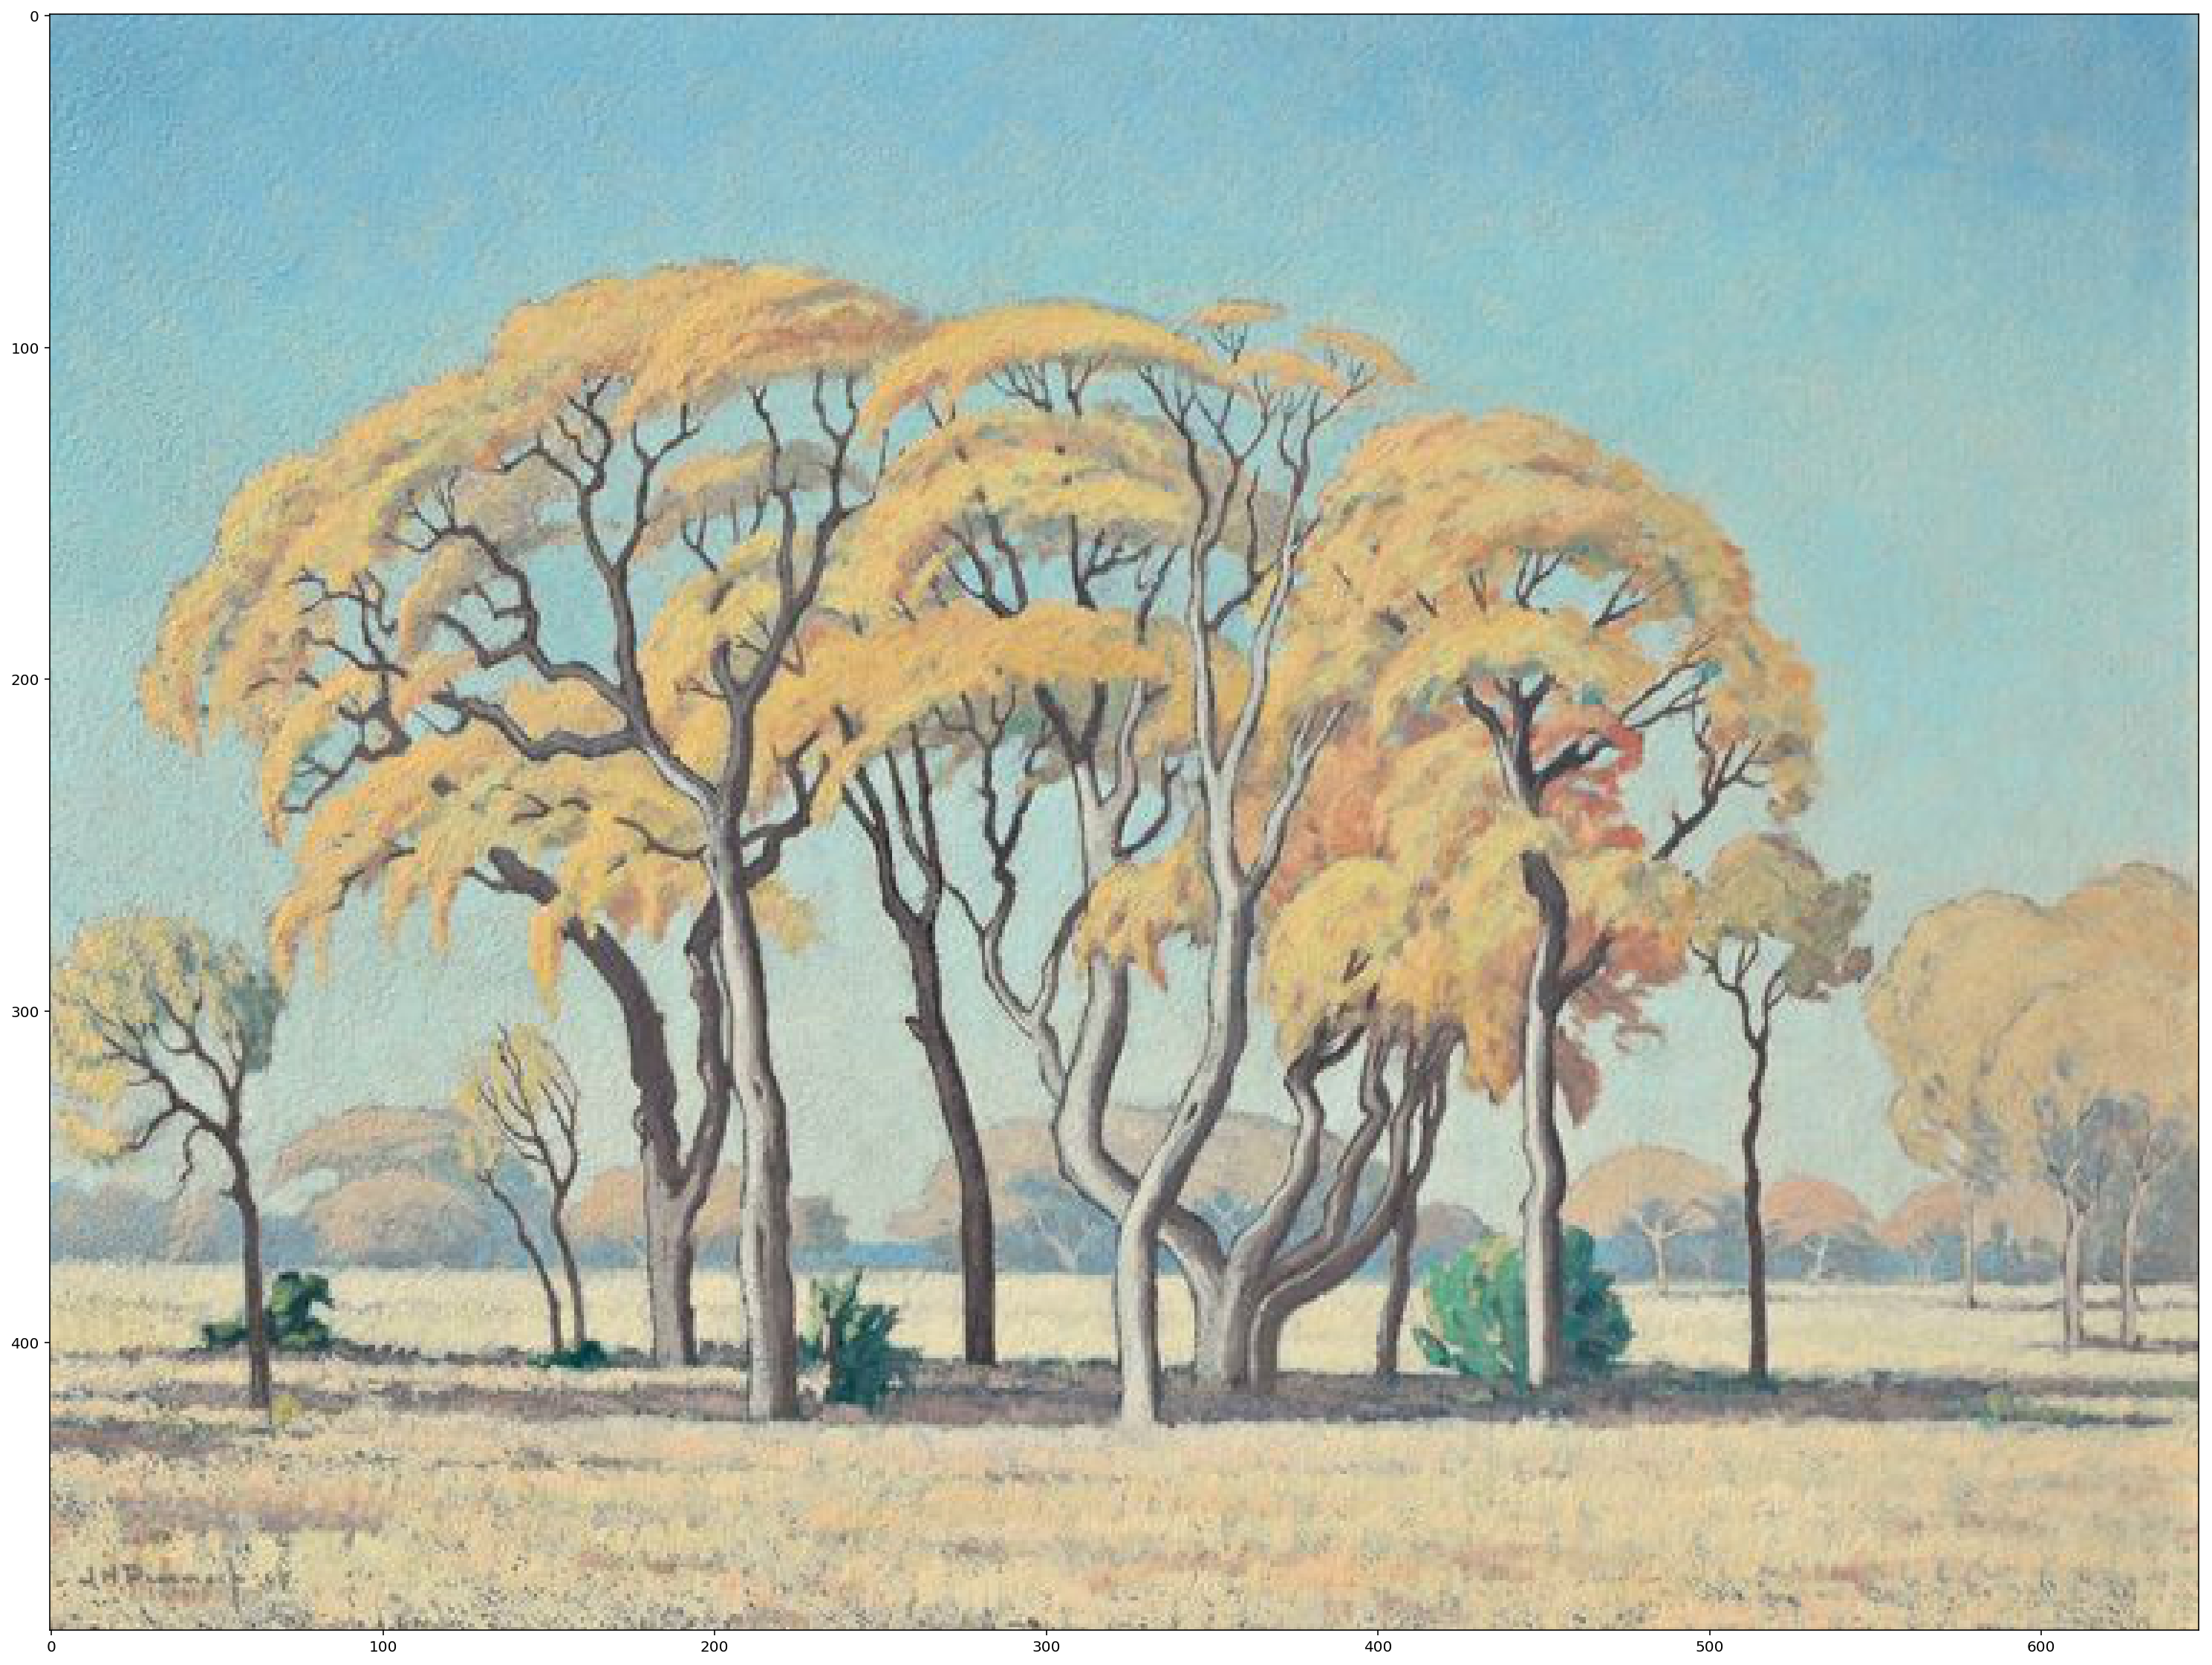

In [10]:
import imageio
im = imageio.imread('tree.jpg')
n, m, c = im.shape
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['figure.dpi'] = 144
plt.imshow(im)
plt.show()

In [11]:
%%time
for i in range(5):
    k = 20
    xs, pis, mus, sigmas = init(k, im)
    pis10, mus10, sigmas10 = em_gmm_orig(xs, pis, mus, sigmas)
    im_new10 = recon_im(n, m, c, k, xs, mus10, sigmas10)
    im_new10 = im_new10.reshape(n, m, c).astype(int)
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['figure.dpi'] = 144   
    plt.imshow(im_new10)
    plt.title('Initiation No. %d' %(i + 1))
    plt.show()

315576 3 20
Iteration: 0, Elapse time: 111.44 sec
Iteration: 1, Elapse time: 112.66 sec
Iteration: 2, Elapse time: 126.28 sec
Iteration: 3, Elapse time: 120.50 sec
Iteration: 4, Elapse time: 123.07 sec
Iteration: 5, Elapse time: 121.85 sec
Iteration: 6, Elapse time: 117.49 sec
Iteration: 7, Elapse time: 114.05 sec
Iteration: 8, Elapse time: 113.76 sec
Iteration: 9, Elapse time: 123.71 sec
Iteration: 10, Elapse time: 125.60 sec
Iteration: 11, Elapse time: 128.48 sec
Iteration: 12, Elapse time: 127.43 sec
Iteration: 13, Elapse time: 117.45 sec
Iteration: 14, Elapse time: 117.60 sec
Iteration: 15, Elapse time: 121.29 sec
Iteration: 16, Elapse time: 120.42 sec
Iteration: 17, Elapse time: 117.59 sec
Iteration: 18, Elapse time: 120.48 sec
Iteration: 19, Elapse time: 123.10 sec
Iteration: 20, Elapse time: 120.42 sec
Iteration: 21, Elapse time: 116.73 sec
Iteration: 22, Elapse time: 116.61 sec
Iteration: 23, Elapse time: 125.58 sec


KeyboardInterrupt: 